# Assignment 4 : Predict Blood Donations

Apolline Chartier-Kastler, Mareme Kane et Guillaume Puy | Groupe 2

# A completer
Question 2 : repondre a la question | Question 4 | Question 8, 9 et 10

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive. We want to predict whether or not a donor will give blood the next time the vehicle comes to campus. <br>
Data is courtesy of Yeh, I-Cheng via the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center).

The dataset contains the following variables:
* Months since Last Donation: this is the number of monthis since this donor's most recent donation.
* Number of Donations: this is the total number of donations that the donor has made.
* Total Volume Donated: this is the total amound of blood that the donor has donated in cubuc centimeters.
* Months since First Donation: this is the number of months since the donor's first donation.

Your goal is to predict the last column, which is whether the donor donated blood in March 2007.

In [90]:
# import necessary libraries 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# show plots in the notebook
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

1-1 load the "transfusion.data" dataset into a dataframe variable called df. Print the shape, head of df

In [91]:
df=pd.read_csv('transfusion.data')
# shape of df
df.shape
df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


1-2 Rename df columns to the following: `['Recency', 'Frequency', 'Volume', 'Time', 'Target']`, then print some info about df

In [92]:
df.columns = ['Recency', 'Frequency', 'Volume', 'Time', 'Target']
df.head()

,Recency,Frequency,Volume,Time,Target
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## Data Exploration

2- Plot a **bar plot** of the column **Target** (% of each class). How much accuracy can you get if prediction is always equal to "*0*" ?

<AxesSubplot:title={'center':'% Target'}, xlabel='Target'>

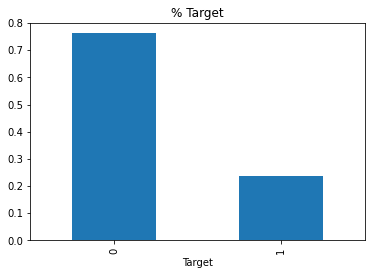

In [93]:
# your code here
%matplotlib inline
import matplotlib.pyplot as plt
(df.groupby('Target').size()/df.shape[0]).plot(x="Target",kind="bar",title="% Target")

In [94]:
# your code here
#How much accuracy can you get if prediction is always equal to "*0*" ?
print("It would be:", df.groupby("Target").size()[0]/df.shape[0])

It would be: 0.7620320855614974


3-1 Print the [Correlation matrix](https://en.wikipedia.org/wiki/Correlation_and_dependence#Correlation_matrices) of df.

In [95]:
# your code here
corr = df.corr()
corr

,Recency,Frequency,Volume,Time,Target
Recency,1.000000,-0.182745,-0.182745,0.160618,-0.279869
Frequency,-0.182745,1.000000,1.000000,0.634940,0.218633
Volume,-0.182745,1.000000,1.000000,0.634940,0.218633
Time,0.160618,0.634940,0.634940,1.000000,-0.035854
Target,-0.279869,0.218633,0.218633,-0.035854,1.000000


3-2 Which are the 2 most correlated variables, make a scatter plot of them. Could you guess how much blood is donated each time ?

<AxesSubplot:xlabel='Frequency', ylabel='Volume'>

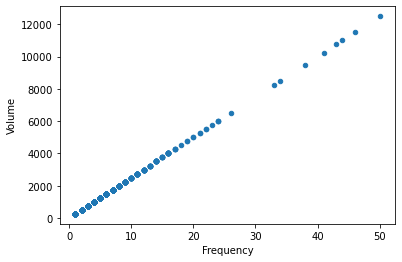

In [96]:
# Volume et Frequency are fully correlated.
c = corr.abs().unstack().drop_duplicates(inplace=False)
correlated = c.sort_values(kind="quicksort",ascending = False)

list_cor =[]
for j in range(len(correlated.index)):
    if list(correlated.index)[j][0]!= list(correlated.index)[j][1]:
        list_cor.append(list(correlated.index)[j][0])
        list_cor.append(list(correlated.index)[j][1])
        break;

list_cor[0]
df.plot.scatter(x=list_cor[0], y=list_cor[1],colormap='viridis')

Frequency * 250 = Volume

Each time, 250 c.c. of blood are donated.

3-3 Remove one of the two most correlated variables above. The choice should have no consequence for the rest, but to have the same results among all students, remove the column with the shortest name (small number of letters)

In [97]:
#Removing Volume
shortest=list_cor[0]

for i in range(len(list_cor)):
    if len(list_cor[i])<len(shortest):
        shortest=list_cor[i]

print(shortest)
df.drop(shortest, axis=1, inplace=True)
df

Volume


,Recency,Frequency,Time,Target
0,2,50,98,1
1,0,13,28,1
2,1,16,35,1
3,2,20,45,1
4,1,24,77,0
...,...,...,...,...
743,23,2,38,0
744,21,2,52,0
745,23,3,62,0
746,39,1,39,0


## Model Training & Evaluation

4- Load the target variable into a dataframe and call it y. Then, load the features into a second dataframe and call it X.

In [98]:
y=df['Target']
X=df.drop('Target',1)
print (X.columns)
df

Index(['Recency', 'Frequency', 'Time'], dtype='object')


,Recency,Frequency,Time,Target
0,2,50,98,1
1,0,13,28,1
2,1,16,35,1
3,2,20,45,1
4,1,24,77,0
...,...,...,...,...
743,23,2,38,0
744,21,2,52,0
745,23,3,62,0
746,39,1,39,0


Fit a logistic model using cross validation. Use 5 folds and print the average accuracy

In [99]:
# Split the data into a training set and a testing set
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size = 0.7,random_state=1)
dfy

,Recency,Frequency,Time,Target
0,2,50,98,1
1,0,13,28,1
2,1,16,35,1
3,2,20,45,1
4,1,24,77,0
...,...,...,...,...
743,23,2,38,0
744,21,2,52,0
745,23,3,62,0
746,39,1,39,0


In [100]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=1)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
print ('train accuracy =', clf.score(X_train, y_train))

train accuracy = 0.7820267686424475


In [101]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5) 
print('cross validation accuracy =', scores.mean())

cross validation accuracy = 0.7727874720357942


In [102]:
clf_log = LogisticRegression(random_state=1)
clf_log.fit(X_train, y_train)

# your code here
scores_log = cross_val_score(clf_log, X, y, scoring='accuracy', cv=5)
print('Score log',scores_log)

Score log [0.76       0.76       0.75333333 0.82550336 0.76510067]


5- Fit a RandomForestClassifier [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) using cross validation. Use 5 folds and print the average accuracy. <br>
Set random_state=1 and play around the other parameters manually to improve the score

In [103]:
# your code here

clf = LogisticRegression(random_state=1)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
print('cross validation accuracy =', scores.mean())

cross validation accuracy = 0.7727874720357942


6- So far, you were told to leave all the parameters to default values, let's now optimize some of them using GridSearchCV. <br>
Search the following parameters in the given values (**This may take a while**):
* min_samples_leaf: [1, 4, 7]
* min_samples_split: [2, 4, 6, 8, 10]
* n_estimators: [20, 30, 40]
* max_depth: [2,3]

In [104]:
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
# your code here
from sklearn.model_selection import GridSearchCV
params = {'min_samples_leaf':list(range(1,8,3)),'min_samples_split':list(range(2,12,2)),
          'n_estimators':list(range(20,50,10)),'max_depth':list(range(2,4))}
clf_rf2=RandomForestClassifier(random_state=1)
clf_gs=GridSearchCV(clf_rf2, params, scoring = 'accuracy',cv=5)
clf_gs.fit(X, y)




GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [2, 3], 'min_samples_leaf': [1, 4, 7],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [20, 30, 40]},
             scoring='accuracy')

7- Print the best score, and the best parameters

In [105]:
print('best score :', clf_gs.best_score_)

best score : 0.7740223713646532


In [106]:
print('best parameters :', clf_gs.best_params_)

best parameters : {'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 30}


8- Build a dataframe containing the importance of each feature. Sort it from the most important to the least one.

In [ ]:
feature_importance = pd.DataFrame(clf_rf2.feature_importances_, X.columns, columns=['Importance'])
feature_importance.sort_values('Importance', ascending=False)
#your code here

9- **Feature engineering**: Try to improve the *RandomForestClassifier* by adding engineered features and using 5 fold grid search for parameter tuning. Print the best score and the best parameters.   
**Hint**: You can achieve 78,6 % accuracy or higher.

In [109]:
clf_rf2 = RandomForestClassifier(random_state=1,  min_samples_leaf=4,max_depth=3,min_samples_split=2, n_estimators=30) 
clf_gs2=GridSearchCV(clf_rf2, params, scoring = 'accuracy',cv=5)
clf_gs2.fit(X, y)
print(clf_gs2.best_score_)

0.7740223713646532


In [110]:
clf_rf2.fit(X_train, y_train)
print ('train accuracy =', clf_rf2.score(X_train, y_train))
print ('test accuracy =', clf_rf2.score(X_test, y_test))
scores_rf2 = cross_val_score(clf_rf2, X, y, scoring='accuracy', cv=5)
print('cross validation accuracy =',scores_rf2.mean())

train accuracy = 0.7762906309751434
test accuracy = 0.7377777777777778
cross validation accuracy = 0.7673736017897091


10- Always in the same setting (5 fold grid search), try different ensemble models from [sklearn](http://scikit-learn.org/stable/modules/ensemble.html#ensemble) in order to get the highest accuracy. Print the best score

In [113]:
# your code here
print(confusion_matrix(y_test,clf_rf2.predict(X_test)))
print(classification_report(y_test,clf_rf2.predict(X_test)))
print(accuracy_score(y_test, clf_rf2.predict(X_test)))

[[165   0]
 [ 59   1]]
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       165
           1       1.00      0.02      0.03        60

    accuracy                           0.74       225
   macro avg       0.87      0.51      0.44       225
weighted avg       0.81      0.74      0.63       225

0.7377777777777778
